# Motivation for Work
Inventory management is one of the most crucial aspects of running a successful retail business. Knowing what products are in demand and when can significantly reduce operational costs and improve customer satisfaction. In today’s data-driven environment, businesses can leverage historical inventory and sales data to make informed decisions.

This Project focuses on analyzing retail store inventory data to classify demand levels using machine learning. By predicting whether the demand for a product is likely to be low, medium, or high, store managers can stock items more efficiently and avoid both overstocking and understocking situations.

We used a real-world dataset containing detailed records of product sales, units ordered, and store activity over time to drive our analysis.

Using techniques such as data preprocessing, feature engineering, and visualization, we aim to build a model that supports smarter inventory planning. This not only streamlines operations but also contributes to better resource allocation and customer service.

## 1. Import Libraries & Load Dataset
Before we can do anything with our data, we need to bring in all the tools we’ll be using. Libraries like pandas, numpy, and matplotlib help us load, analyze, and visualize data. sklearn provides ready-to-use machine learning tools.

Once the libraries are loaded, we read the CSV file that contains our retail inventory data. This file includes columns like Date, Store ID, Product ID, Units Ordered, and others that reflect daily operations of a retail store.

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [80]:
df = pd.read_csv("retail_store_inventory.csv")

## 2. Dataset Summary
Now that our data is loaded, it’s time to get a basic feel for what we’re working with. We start by checking the top rows using head() to see what the dataset looks like.

We then check:
- How many rows and columns there are,
- What data types each column has using info(),
- Basic statistical summaries using describe().

These steps help us detect early issues such as unexpected data types or obviously incorrect values (e.g., negative units sold).

In [82]:
print("Sample data:")
df.head()

Sample data:


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [22]:
df.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

In [24]:
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset has 73100 rows and 15 columns.


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [28]:
print("\nSummary Statistics for Numerical Columns:")
df.describe()


Summary Statistics for Numerical Columns:


,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


## 3. Handling Missing Values and Data Cleaning
During data preprocessing, we often encounter missing values, especially in lag and rolling features created from time-series data. These missing values occur because calculations like lag or rolling averages require previous data points that may not exist at the start of the dataset. To address this, we use backward fill (bfill), which fills missing entries with the next valid value in the column. This approach preserves all rows, preventing data loss and ensuring the machine learning model does not encounter errors caused by NaN values. After this step, the dataset is clean and ready for further processing.

In [31]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


In [33]:
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\nFrequency counts for {col}:")
    print(df[col].value_counts())
    print(f"Percentage distribution for {col}:")


Frequency counts for Date:
Date
2022-01-01    100
2023-04-26    100
2023-04-28    100
2023-04-29    100
2023-04-30    100
             ... 
2022-09-03    100
2022-09-04    100
2022-09-05    100
2022-09-06    100
2024-01-01    100
Name: count, Length: 731, dtype: int64
Percentage distribution for Date:

Frequency counts for Store ID:
Store ID
S001    14620
S002    14620
S003    14620
S004    14620
S005    14620
Name: count, dtype: int64
Percentage distribution for Store ID:

Frequency counts for Product ID:
Product ID
P0001    3655
P0002    3655
P0019    3655
P0018    3655
P0017    3655
P0016    3655
P0015    3655
P0014    3655
P0013    3655
P0012    3655
P0011    3655
P0010    3655
P0009    3655
P0008    3655
P0007    3655
P0006    3655
P0005    3655
P0004    3655
P0003    3655
P0020    3655
Name: count, dtype: int64
Percentage distribution for Product ID:

Frequency counts for Category:
Category
Furniture      14699
Toys           14643
Clothing       14626
Groceries      14611
Elect

In [35]:
print("\nAdditional Statistics:")
print(f"Total number of stores: {df['Store ID'].nunique()}")
print(f"Total number of products: {df['Product ID'].nunique()}")
print(f"Date range: from {df['Date'].min()} to {df['Date'].max()}")


Additional Statistics:
Total number of stores: 5
Total number of products: 20
Date range: from 2022-01-01 to 2024-01-01


## 4. Exploratory Data Analysis (EDA) and Visualization
EDA helps us understand the data more intuitively. We explore the frequency distribution of categorical values like store and product types.

After converting the Date column to a datetime object, we examine:
- The number of unique stores and products,
- The time range covered by the dataset.

We create several visualizations:
- A daily sales line chart to see spikes and drops in units sold,
- A monthly trend to observe seasonal patterns,
- A histogram to check the distribution of Units Sold,
- A correlation heatmap to find relationships between numeric features.

This step helps us detect patterns, trends, and outliers that guide our modeling choices.


In [38]:
df['Date'] = pd.to_datetime(df['Date'])
daily_sales = df.groupby('Date')['Units Sold'].sum().reset_index()

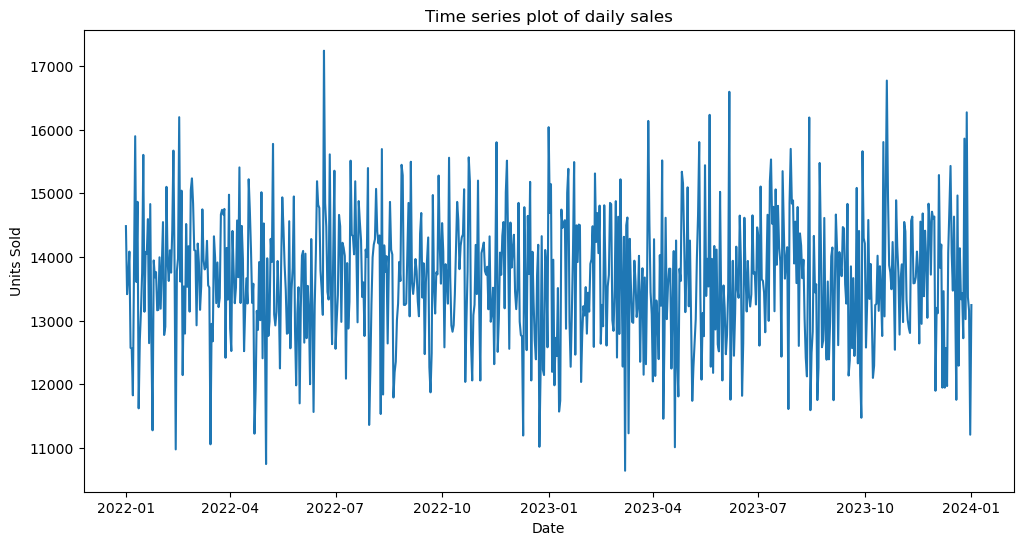

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['Date'], daily_sales['Units Sold'])
plt.title('Time series plot of daily sales')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

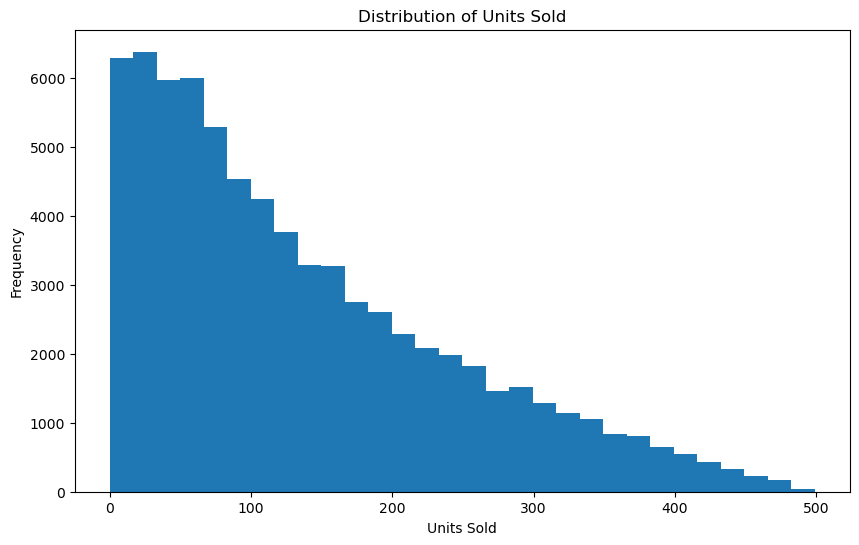

In [42]:
plt.figure(figsize=(10, 6))
plt.hist(df['Units Sold'], bins=30)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

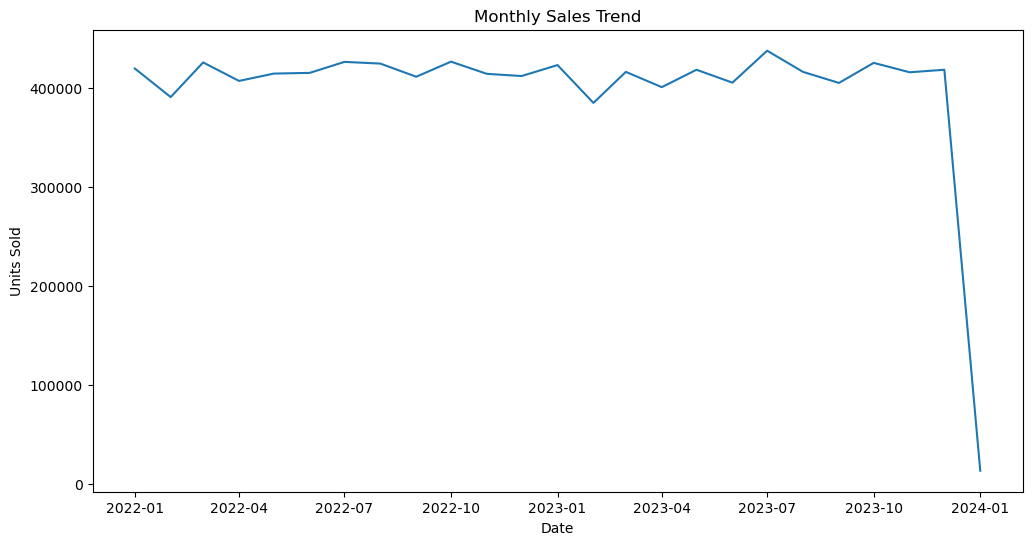

In [44]:
monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Units Sold'].sum().reset_index()
monthly_sales['Date'] = monthly_sales['Date'].dt.to_timestamp()
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Date'], monthly_sales['Units Sold'])
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

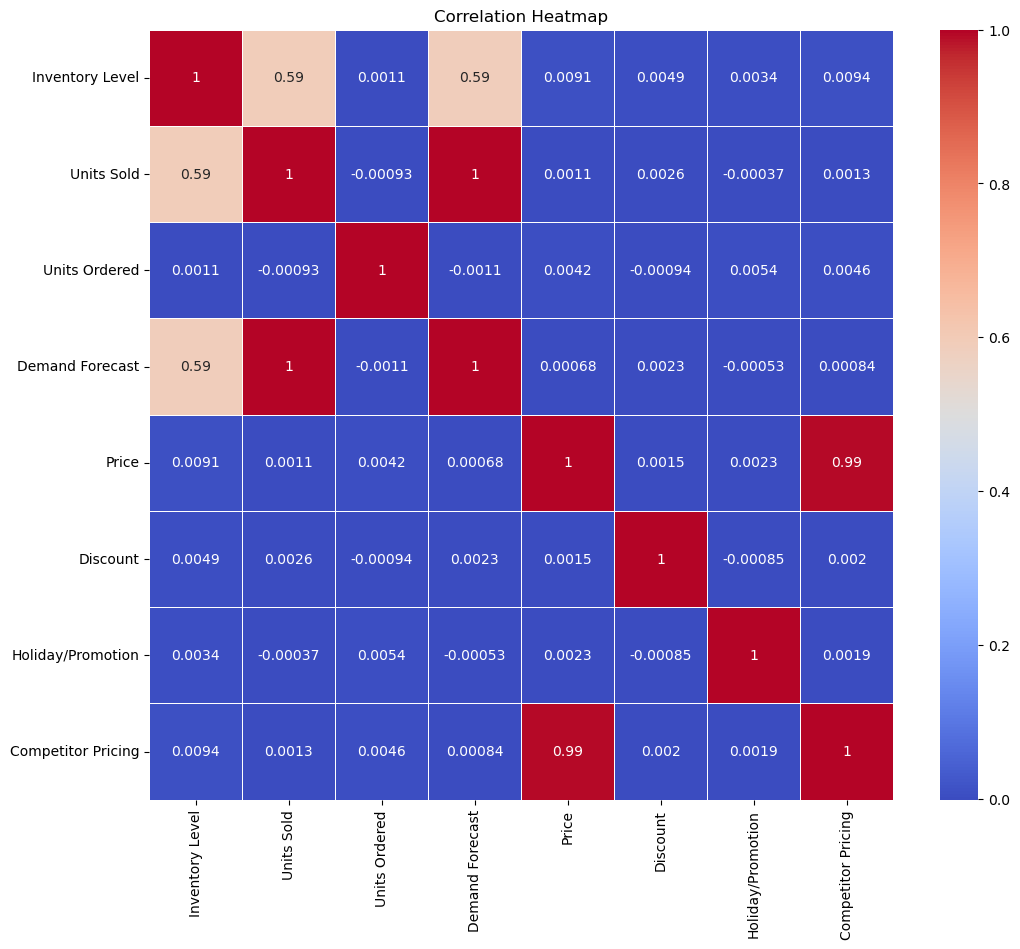

In [46]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## 5. Feature Engineering
To improve model performance, we derive additional features from existing ones. From the Date column, we extract:
- Whether the day is a weekend,
- The quarter, month, and weekday.

We also generate lag features (e.g., units ordered 1, 2, 3 days ago) and rolling average features (e.g., average units ordered over the last 3, 7, or 14 days). These features are common in time-series forecasting and help the model learn from past behavior.

With these engineered features, we enrich the dataset with temporal patterns and trends.

In [84]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce') 
df['Is_Weekend'] = df['Date'].dt.weekday >= 5
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday

In [89]:
for lag in [1, 2, 3, 7, 14]:
    df[f'Units_Ordered_Lag_{lag}'] = df['Units Ordered'].shift(lag)

for window in [3, 7, 14]:
    df[f'Units_Ordered_RollMean_{window}'] = df['Units Ordered'].rolling(window=window).mean()

df.fillna(method='bfill', inplace=True)

C:\Users\thaka\AppData\Local\Temp\ipykernel_10868\177449099.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


## 6. Demand Labeling and Encoding
Next, we prepare the target variable for our classification model. Instead of predicting the exact quantity ordered, we simplify the problem by creating a demand level:
- Low
- Medium
- High

This is done using pd.qcut(), which splits the continuous Units Ordered column into 3 equal parts. This allows us to reframe the problem as a multi-class classification task.

We also encode all object-type columns (except the target) into numeric values using LabelEncoder, making the dataset fully numeric and model-ready.


In [54]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df['Day'] = df['Date'].dt.day
df = df.drop('Date', axis=1)
df['Demand_Level'] = pd.qcut(df['Units Ordered'], q=3, labels=['Low', 'Medium', 'High'])

In [56]:
label_enc = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if col != 'Demand_Level':
        df[col] = label_enc.fit_transform(df[col])

## 7. Model Training and Evaluation
Now we split our data into training and testing sets (80/20 ratio) using train_test_split. Before feeding the data into a machine learning model, we standardize the features using StandardScaler, which ensures all values are on the same scale.

We then train a Random Forest Classifier, a powerful ensemble learning method that works well with classification problems and can handle non-linear data.

After fitting the model on training data, it’s ready to make predictions on unseen test data.

After the model predicts the demand level, we assess its performance using:
- Classification report – precision, recall, F1-score for each class.
- Accuracy score – overall correct predictions.
- Confusion matrix – visualizes how well each demand level was predicted.
- F1-score bar chart – shows how balanced and accurate the model is for each class.


In [61]:
X = df.drop(['Demand_Level', 'Units Ordered'], axis=1)
y = df['Demand_Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [67]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [69]:
y_pred = clf.predict(X_test)
print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print(" Accuracy Score:", accuracy_score(y_test, y_pred))


 Classification Report:
              precision    recall  f1-score   support

        High       0.92      0.95      0.93      4883
         Low       0.91      0.95      0.93      4933
      Medium       0.88      0.81      0.85      4804

    accuracy                           0.90     14620
   macro avg       0.90      0.90      0.90     14620
weighted avg       0.90      0.90      0.90     14620

 Accuracy Score: 0.9026675786593708


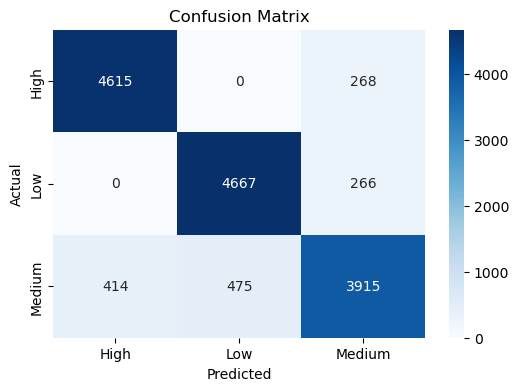

In [71]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

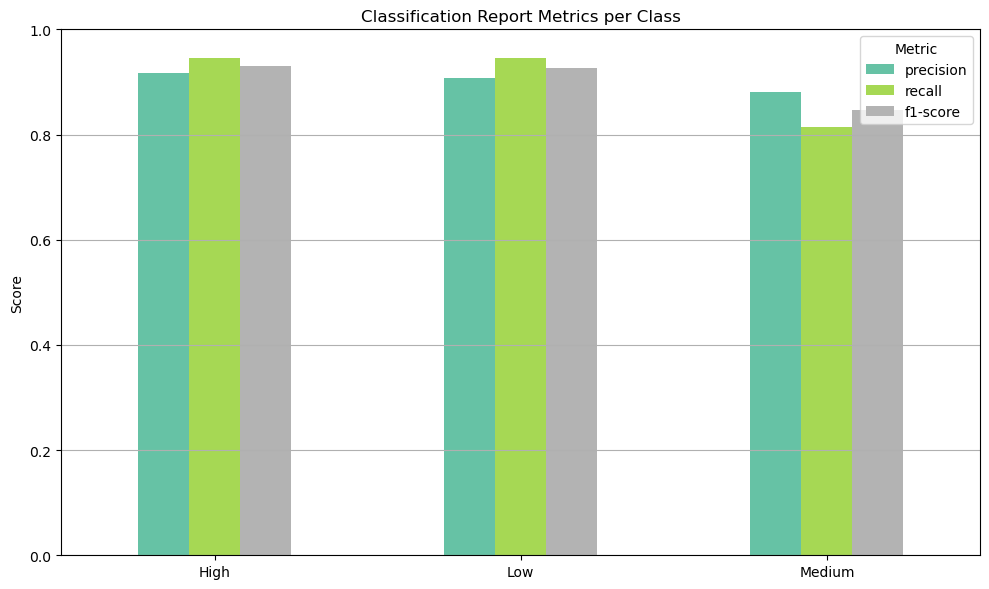

In [73]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

report_df.plot(kind='bar', figsize=(10,6), colormap='Set2')
plt.title("Classification Report Metrics per Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title="Metric")
plt.tight_layout()
plt.show()